In [3]:
# This is a sample Python script.

# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
#Import pandas
import pandas as pd
import time
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import wordnet
from collections import Counter

#Instantiate Stemmer
stemmer = PorterStemmer()
def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text
def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len([item for item in probable_part_of_speech if item.pos() == "n"])
    pos_counts["v"] = len([item for item in probable_part_of_speech if item.pos() == "v"])
    pos_counts["a"] = len([item for item in probable_part_of_speech if item.pos() == "a"])
    pos_counts["r"] = len([item for item in probable_part_of_speech if item.pos() == "r"])

    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i, get_part_of_speech(i)) for i in text]
    return lem_text

def removeNumber(text):
    return' '.join(re.sub(r'[0-9]',' ', text).split())
def deEmojify(text):
    return text.encode('ascii', 'ignore').decode('ascii')
def remove_stopwords(text):
    stpwrd = nltk.corpus.stopwords.words('english')
    text = text.split(" ")
    words = [w for w in text if w not in stpwrd]
    return ' '.join(words)
def removePunctuation(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc
def removeLink(text):
    no_link = ' '.join(re.sub("(w+://S+)", " ", text).split())
    return no_link
def preprocess(content): #res -> clean_content
    clean_content = content.lower()
    # removeLinks
    clean_content = removeLink(clean_content)
    # remove stop words
    clean_content = remove_stopwords(clean_content)
    # removePunc
    clean_content = removePunctuation(clean_content)
    # removeEmojis
    clean_content = deEmojify(clean_content)
    # removeNumber
    clean_content = removeNumber(clean_content)
    # tokenizer
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
    clean_content = tokenizer.tokenize(clean_content)
    # lemmatizer
    clean_content = word_lemmatizer(clean_content)
    # stemmer
    #clean_content = word_stemmer(clean_content)
    return clean_content
def prepare_data(dataset):
#prepare_data(df, stemmer='lan', spellcheck=False):
    start_time = time.time()
    dataset['clean_content'] = [preprocess(x) for x in dataset['content']]
    #if spellcheck: df.to_csv("/Users/neel/Desktop/bigsample_spellchecked.csv")
    print("--- %s seconds ---" % (time.time() - start_time))
    return dataset
def get_data(file):
    data = pd.read_csv(file)
    print(data.shape)
    return data

In [4]:
file = "../final_annotations.csv"
# prepare the data
print("preprocessing data...")
dataset = prepare_data(get_data(file))
print("done preprocessing data...")
print(len(dataset))


preprocessing data...
(3097, 16)
--- 4.589451789855957 seconds ---
done preprocessing data...
3097


In [5]:
df = dataset.query("aacat1 not in ['Noise', 'none']")
#df['aacat1'].unique()
corpus_list = df['clean_content'].tolist()
#corpus_list

In [6]:
#For Apriori algorithm, this dataset needs to be one-hot encoded.
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(corpus_list).transform(corpus_list)
corpus_df = pd.DataFrame(te_ary, columns=te.columns_)
corpus_df

,a,aa,aap,ab,abbreviate,ability,able,ableism,ableist,aboslutely,...,yu,zac,zayanbutt,zero,zindabad,zone,zoom,zoomyesterday,zuck,zuckerberg
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1918,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1919,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1920,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
#rule = apriori(transactions = corpus_list, min_support = 0.005, min_confidence = 0.05, min_lift = 3, min_length = 2, max_length = 2)
from mlxtend.frequent_patterns import apriori
import time
start_time = time.time()
frequent_itemsets = apriori(corpus_df, min_support = 0.003, use_colnames=True)
print("---Runtime: %s seconds ---" % (time.time() - start_time))
#API: apriori(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0, low_memory=False)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print("the number of frequent itemsets generated:", len(frequent_itemsets))
frequent_itemsets


---Runtime: 49.013065814971924 seconds ---
the number of frequent itemsets generated: 15746


,support,itemsets,length
0,0.003122,(a),1
1,0.017170,(able),1
2,0.004162,(about),1
3,0.003122,(absolute),1
4,0.018210,(absolutely),1
...,...,...,...
15741,0.004683,"(app, community, violate, guideline, video, re...",6
15742,0.003642,"(app, violate, guideline, content, video, report)",6
15743,0.003122,"(driver, uber, even, cancel, trip, charge)",6
15744,0.004162,"(community, violate, guideline, content, video...",6


1. Support - It is the measure of frequency or abundance of an item in a dataset. It can be 'antecedent support', 'consequent support', and 'support'. 'antecedent support' contains proportion of transactions done for the antecedent while 'consequent support' involves those for consequent. 'Support' is computed for both antecedent and consequent in question.
2. Confidence - This gives the probability of consequent in a transaction given the presence of antecedent.
3. Lift - Given that antecedents and consequents are independent, how often do they come together/bought together.
4. Leverage - It is the difference between frequency of antecedent and consequent together in transactions to frequency of both in independent transactions.
5. Conviction - A higher conviction score means that consequent is highly dependent on antecedent.

In [8]:
from mlxtend.frequent_patterns import association_rules
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=9)
#rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
#rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules
#display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(cannot),(access),0.022373,0.037981,0.013528,0.604651,15.919720,0.012678,2.433341,0.958632
1,(access),(cannot),0.037981,0.022373,0.013528,0.356164,15.919720,0.012678,1.518443,0.974186
2,(password),(access),0.005723,0.037981,0.003642,0.636364,16.754670,0.003425,2.645552,0.945728
3,(access),(password),0.037981,0.005723,0.003642,0.095890,16.754670,0.003425,1.099730,0.977440
4,(accessibility),(caption),0.007284,0.007284,0.005203,0.714286,98.061224,0.005150,3.474506,0.997065
...,...,...,...,...,...,...,...,...,...,...
12455,(community),"(app, violate, guideline, content, video, report)",0.047347,0.003642,0.003122,0.065934,18.103611,0.002949,1.066689,0.991717
12456,(violate),"(app, community, guideline, content, video, re...",0.027575,0.003122,0.003122,0.113208,36.264151,0.003036,1.124139,1.000000
12457,(guideline),"(app, community, violate, content, video, report)",0.037461,0.003122,0.003122,0.083333,26.694444,0.003005,1.087504,1.000000
12458,(content),"(app, community, violate, guideline, video, re...",0.072841,0.004683,0.003122,0.042857,9.152381,0.002781,1.039884,0.960718


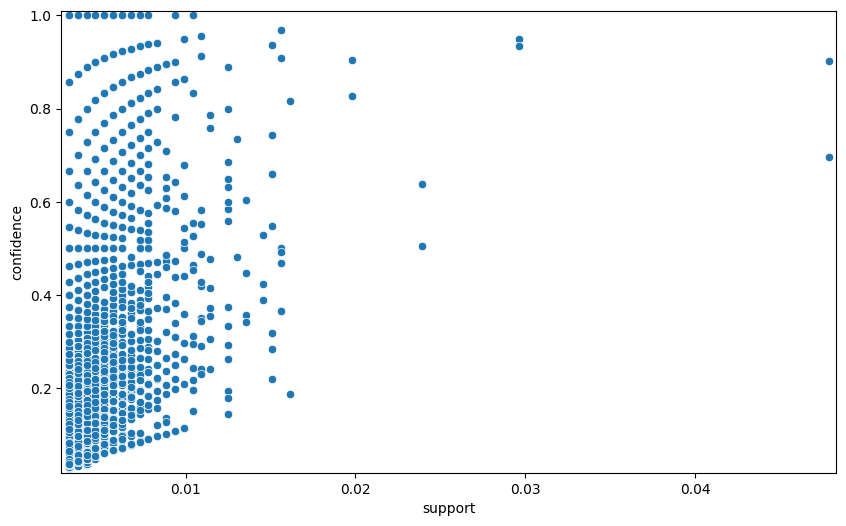

In [9]:
# Generate scatterplot using support and confidence
import matplotlib.pyplot as plt
import seaborn as sns1
plt.figure(figsize=(10,6))
sns1.scatterplot(x = "support", y = "confidence", data = rules)
plt.margins(0.01,0.01)
plt.show()

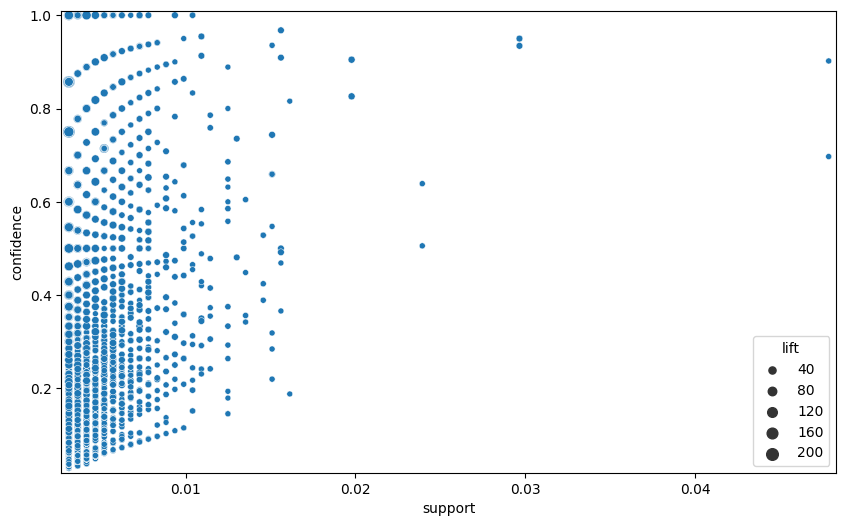

In [10]:
# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns1.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.margins(0.01,0.01)
plt.show()

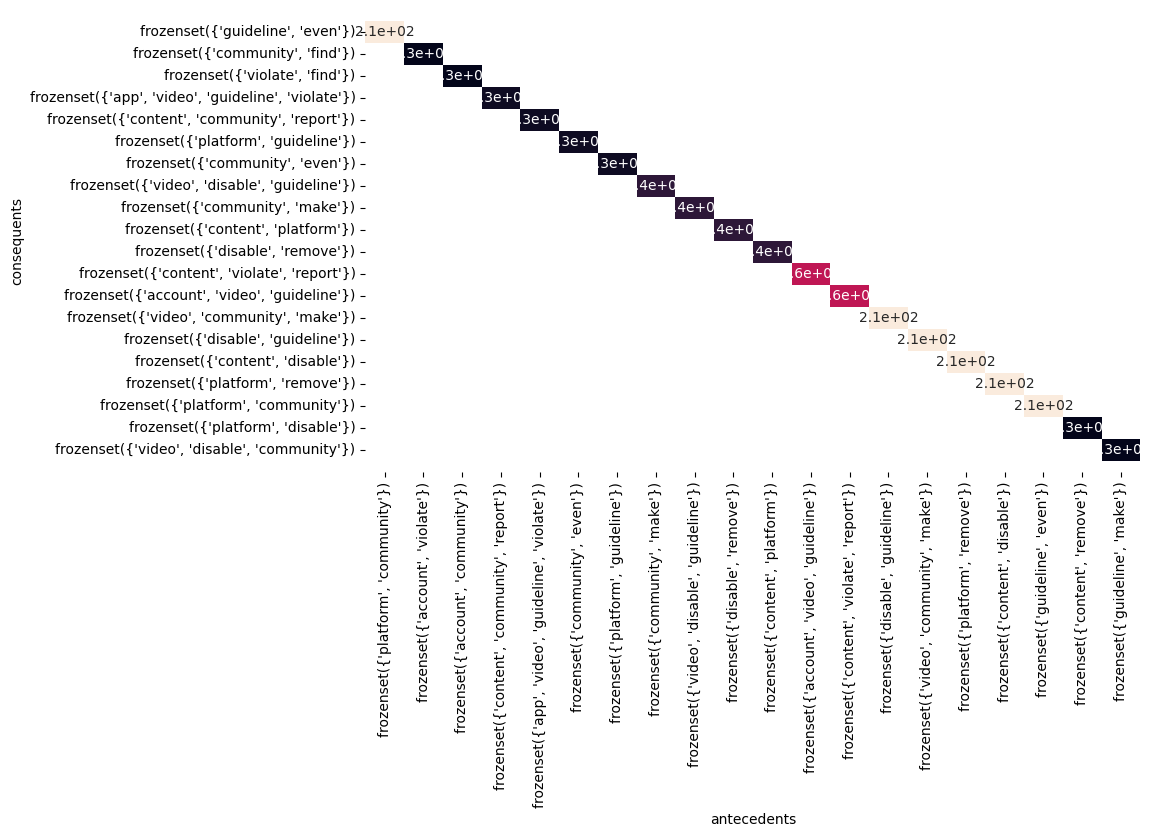

In [11]:
# Transform the DataFrame of rules into a matrix using the lift metric
import seaborn as sns1
rules_top = rules.nlargest(n = 20, columns = 'lift')

pivot = rules_top.pivot(index = 'consequents', 
                    columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns1.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

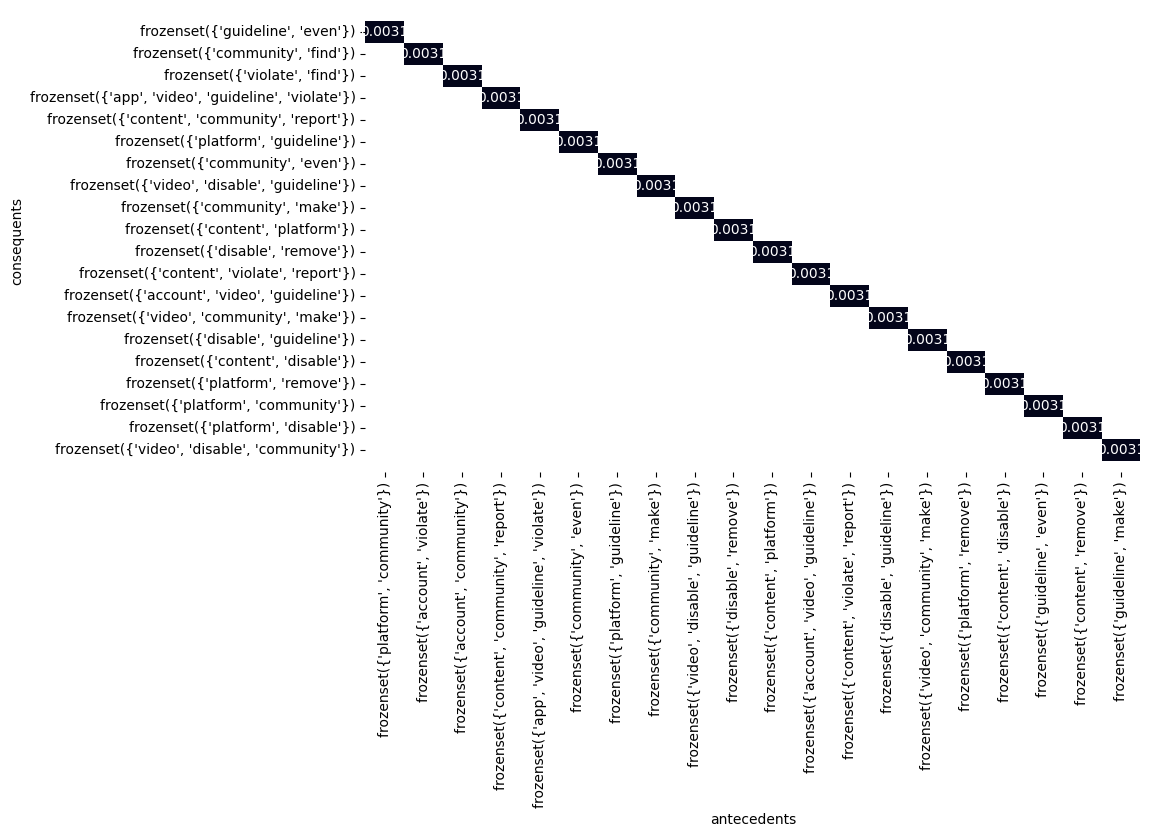

In [12]:
# Transform antecedent, consequent, and support columns into matrix
support_table = rules_top.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(10,6))
sns1.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show() 


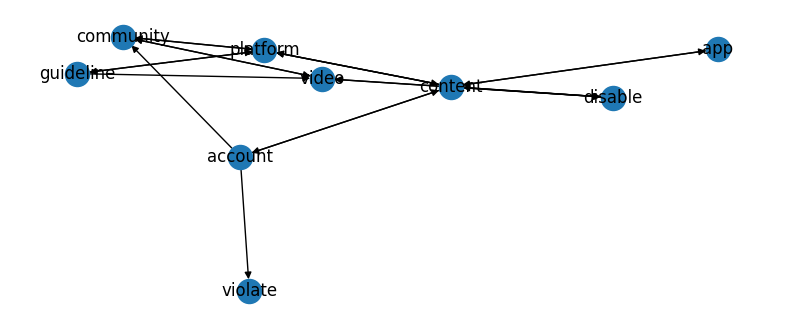

In [17]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=9)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules_top = rules.nlargest(n = 20, columns = 'lift')

import networkx as nx
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules_top,source='antecedents',target='consequents', create_using = nx.MultiDiGraph(), edge_attr='lift')

nx.draw(GA, with_labels=True)
plt.show()


In [16]:
rules_top

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
7683,platform,guideline,0.004162,0.003642,0.003122,0.750000,205.928571,0.003107,3.985432,0.999303
7686,guideline,platform,0.003642,0.004162,0.003122,0.857143,205.928571,0.003107,6.970864,0.998782
8043,content,platform,0.004162,0.003642,0.003122,0.750000,205.928571,0.003107,3.985432,0.999303
8046,platform,content,0.003642,0.004162,0.003122,0.857143,205.928571,0.003107,6.970864,0.998782
11526,video,disable,0.004162,0.003642,0.003122,0.750000,205.928571,0.003107,3.985432,0.999303
11541,disable,video,0.003642,0.004162,0.003122,0.857143,205.928571,0.003107,6.970864,0.998782
11791,content,account,0.005203,0.003642,0.003122,0.600000,164.742857,0.003103,2.490895,0.999128
11794,account,content,0.003642,0.005203,0.003122,0.857143,164.742857,0.003103,6.963580,0.997563
8042,content,disable,0.006243,0.003642,0.003122,0.500000,137.285714,0.003099,1.992716,0.998953
8047,disable,content,0.003642,0.006243,0.003122,0.857143,137.285714,0.003099,6.956296,0.996345
